In [1]:
import cmcrameri.cm as cmc
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import Array

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")

from femsolver.jax_utils import auto_vmap, vmap
from femsolver.operator import Operator
from femsolver.quadrature import Element, Tri3

In [5]:
from femsolver.operator import Mesh
from femsolver.operator_refactored import Operator as OperatorRefactored


tri = Tri3()
tri.shape_function_derivative((1 / 3, 1 / 3))

mesh = Mesh.unit_square(10, 10)
op = Operator(mesh, tri)
opr = OperatorRefactored(mesh, tri)


@opr.eval_at_quad
def energy_density(u: Array, u_grad: Array, *_: Array) -> Array:
    """Energy density for the Poisson equation."""
    return 73


u = jnp.zeros((mesh.nodes.shape[0], 2))
energy_density(u)

Array([[73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],
       [73],

In [6]:
def generate_unit_square_mesh_tri(nx: int, ny: int) -> tuple[Array, Array]:
    """Generate a uniform mesh of triangles over the unit square [0, 1] x [0, 1]."""
    x = jnp.linspace(0, 1, nx + 1)
    y = jnp.linspace(0, 1, ny + 1)
    xv, yv = jnp.meshgrid(x, y, indexing="ij")
    coords = jnp.stack([xv.ravel(), yv.ravel()], axis=-1)

    def node_id(i, j):
        return i * (ny + 1) + j

    elements = []
    for i in range(nx):
        for j in range(ny):
            n0 = node_id(i, j)
            n1 = node_id(i + 1, j)
            n2 = node_id(i, j + 1)
            n3 = node_id(i + 1, j + 1)
            elements.append([n0, n1, n3])
            elements.append([n0, n3, n2])
    return coords, jnp.array(elements)


# --- Mesh ---
coords, elements = generate_unit_square_mesh_tri(10, 10)
n_nodes = coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

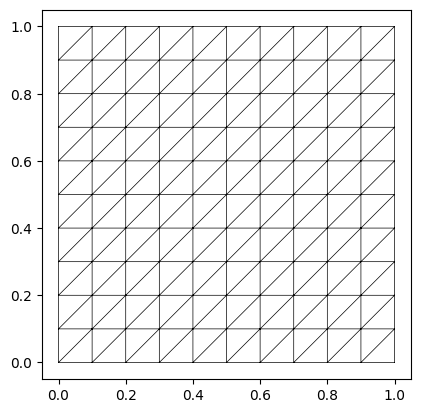

In [7]:
plt.triplot(*coords.T, elements, color="k", lw=0.5)
plt.gca().set_aspect("equal")

In [8]:
from enum import auto


@auto_vmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    """Compute the strain tensor from the gradient of the displacement."""
    return 0.5 * (grad_u + grad_u.swapaxes(-1, -2))


@auto_vmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps: Array, mu: float, lmbda: float) -> Array:
    """Compute the stress tensor from the strain tensor."""
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I


@auto_vmap(grad_u=2, mu=0, lmbda=0)
def strain_energy(grad_u: Array, mu: float, lmbda: float) -> Array:
    """Compute the strain energy density."""
    eps = compute_strain(grad_u)
    sig = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(eps * sig)

In [ ]:
class ElasticityOperator(Operator):
    element: Element
    mu: float
    lmbda: float

    @auto_vmap(xi=1, wi=1, nodal_values=None, nodes=None)
    def integrand(self, xi, wi, nodal_values, nodes):
        u_quad, u_grad, detJ = self.element.get_local_values(xi, nodal_values, nodes)
        value = strain_energy(u_grad, self.mu, self.lmbda)
        return wi * value * detJ


fem = ElasticityOperator(
    element=element.Tri3(),
    mu=1.0,
    lmbda=1.0,
)

In [12]:
def compute_contact_energy(
    u_flat: jnp.ndarray, coords: jnp.ndarray, contact_nodes: jnp.ndarray
) -> jnp.ndarray:
    """
    Compute the contact energy for a given displacement field.
    Args:
        u_flat: Flattened displacement field.
        coords: Coordinates of the nodes.
        contact_nodes: Indices of the nodes on the contact surface.
    Returns:
        Contact energy.
    """
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_nodes = u[contact_nodes]
    x_nodes = coords[contact_nodes]

    k_pen = 1e2
    node_area_weight = 1.0  # TODO: add the correctarea of the node

    # Loop over nodes on the potential contact surface
    @vmap(in_axes=(0, 0))
    def contact_energy_node(u_node, x_node):
        gap = (x_node[0] + u_node[0]) - 0.0
        penetration = jnp.maximum(-gap, 0.0)
        return 0.5 * k_pen * (penetration**2) * node_area_weight

    return jnp.sum(contact_energy_node(u_nodes, x_nodes))


# --- Total energy ---
def total_energy(
    u_flat: jnp.ndarray,
    coords: jnp.ndarray,
    elements: jnp.ndarray,
    fem: Operator,
    contact_nodes: jnp.ndarray,
) -> jnp.ndarray:
    """
    Compute the total energy for a given displacement field.
    Args:
        u_flat: Flattened displacement field.
        coords: Coordinates of the nodes.
        elements: Element indices.
        fem: Operator object.
        contact_nodes: Indices of the nodes on the contact surface.
    Returns:
        Total energy.
    """
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_cell = u[elements]
    x_cell = coords[elements]
    elastic_energy = jnp.sum(fem.integrate(u_cell, x_cell))

    # --- Contact energy ---
    contact_energy = compute_contact_energy(u_flat, coords, contact_nodes)

    return elastic_energy + contact_energy

In [14]:
u = jnp.zeros(n_dofs)

residual = jax.grad(total_energy)
hessian = jax.jacfwd(residual)

contact_nodes = jnp.where(jnp.isclose(coords[:, 0], 0.0))[0]
right_nodes = jnp.where(jnp.isclose(coords[:, 0], 1.0))[0]

fixed_dofs = jnp.concatenate([2 * right_nodes])
prescribed_values = jnp.zeros_like(u).at[2 * right_nodes].set(-0.3)
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

K = hessian(u, coords, elements, fem, contact_nodes)
f_int = residual(u, coords, elements, fem, contact_nodes)


# --- Solve for the displacement ---
# We are using a linear solver here but ideally we would use a Newton solver
# TODO: use Newton solver
f_ext = -f_int - K @ prescribed_values
f_reduced = f_ext[free_dofs]
K_reduced = K[jnp.ix_(free_dofs, free_dofs)]
u_free = jnp.linalg.solve(K_reduced, f_reduced)
u_full = prescribed_values.at[free_dofs].set(u_free)